In [1]:
import os

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import tqdm

from IPython import display

In [2]:
DATASETS = [
    'cityscapes.tar.gz',
    'edges2handbags.tar.gz',
    'edges2shoes.tar.gz',
    'facades.tar.gz',
    'maps.tar.gz',
]


_URL = 'https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/'

path_to_zip = tf.keras.utils.get_file(DATASETS[0],
                                      origin=_URL + DATASETS[0],
                                      extract=True)

PATH = os.path.join(os.path.dirname(path_to_zip), DATASETS[0][:DATASETS[0].find('.')]) + '/'
print(PATH)

/home/kiddoos831007/.keras/datasets/cityscapes/


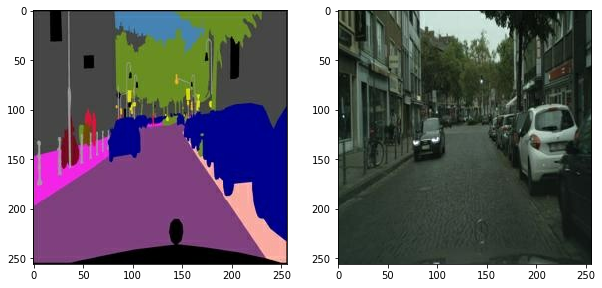

In [4]:
def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)

    w = tf.shape(image)[1]

    w = w // 2
    input_image = image[:, w:, :]
    output_image = image[:, :w, :]

    input_image = tf.cast(input_image, tf.float32)
    output_image = tf.cast(output_image, tf.float32)

    return input_image, output_image


test_input_image, test_output_image = load(PATH+'train/100.jpg')

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(test_input_image / 255.0)
plt.subplot(1, 2, 2)
plt.imshow(test_output_image / 255.0)
plt.show()

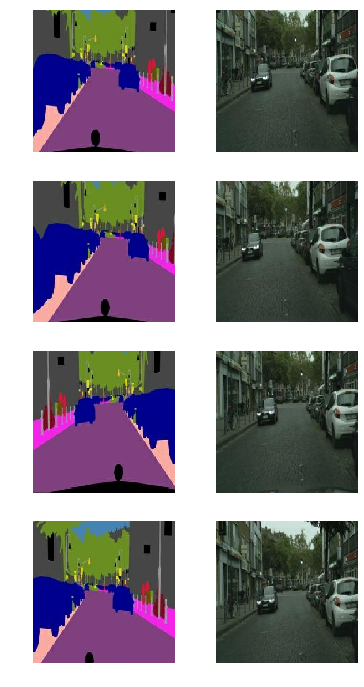

In [5]:
IMAGE_SIZE = 256


def resize(input_image, output_image, height, width):
    input_image = tf.image.resize(input_image, [height, width],
                                  method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    output_image = tf.image.resize(output_image, [height, width],
                                   method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return input_image, output_image


def random_crop(input_image, output_image):
    stacked_image = tf.stack([input_image, output_image], axis=0)
    cropped_image = tf.image.random_crop(
        stacked_image, size=[2, IMAGE_SIZE, IMAGE_SIZE, 3])

    return cropped_image[0], cropped_image[1]


def normalize(input_image, output_image):
    input_image = (input_image / 255.0)
    output_image = (output_image / 255.5)

    return input_image, output_image


@tf.function()
def random_jitter(input_image, output_image):
    # resizing to 286 x 286 x 3
    input_image, output_image = resize(input_image, output_image, 300, 300)

    # randomly cropping to 256 x 256 x 3
    input_image, output_image = random_crop(input_image, output_image)

    if tf.random.uniform(()) > 0.5:
        # random mirroring
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(output_image)

    return input_image, output_image


plt.figure(figsize=(6, 12))
n_sample = 4
for i in range(n_sample):
    rp_input_image, rp_output_image = random_jitter(test_input_image, test_output_image)
    plt.subplot(n_sample, 2, i*2+1)
    plt.imshow(rp_input_image / 255.0)
    plt.axis('off')
    
    plt.subplot(n_sample, 2, i*2+2)
    plt.imshow(rp_output_image / 255.0)
    plt.axis('off')
plt.show()

In [6]:
BUFFER_SIZE = 200
BATCH_SIZE = 1

def train_pipeline(image_file):
    input_image, output_image = load(image_file)
    input_image, output_image = random_jitter(input_image, output_image)
    input_image, output_image = normalize(input_image, output_image)

    return input_image, output_image


def test_pipeline(image_file):
    input_image, output_image = load(image_file)
    input_image, output_image = resize(input_image, output_image,
                                       IMAGE_SIZE, IMAGE_SIZE)
    input_image, output_image = normalize(input_image, output_image)

    return input_image, output_image


# train
train_dataset = tf.data.Dataset.list_files(PATH+'train/*.jpg')
train_dataset = train_dataset.map(train_pipeline,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)

train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)
print(train_dataset)

# test
test_dataset = tf.data.Dataset.list_files(PATH+'val/*.jpg')
test_dataset = test_dataset.map(test_pipeline)
test_dataset = test_dataset.batch(BATCH_SIZE)

print(test_dataset)

<DatasetV1Adapter shapes: ((None, 256, 256, 3), (None, 256, 256, 3)), types: (tf.float32, tf.float32)>
<DatasetV1Adapter shapes: ((None, 256, 256, None), (None, 256, 256, None)), types: (tf.float32, tf.float32)>


In [7]:
def downsample(x, output_size, ksize, strides):
    x = keras.layers.Conv2D(output_size, ksize, strides=strides, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.LeakyReLU()(x)
    return x


def upsample(x, output_size, ksize, strides):
    x = keras.layers.Conv2DTranspose(output_size, ksize, strides=strides, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)
    return x

def residual_upsample(x, r, output_size, ksize, strides):
    x = upsample(x, output_size, ksize, strides)
    r = keras.layers.Concatenate(axis=3)([x, r])
    return r


def build_generator_unet():
    input_image = keras.layers.Input(shape=[IMAGE_SIZE, IMAGE_SIZE, 3])
    x1 = downsample(input_image, 64, 4, strides=2)
    x2 = downsample(x1, 128, 4, strides=2)
    x3 = downsample(x2, 256, 4, strides=2)
    x4 = downsample(x3, 512, 4, strides=2)
    x5 = downsample(x4, 512, 4, strides=2)
    x6 = downsample(x5, 512, 4, strides=2)
    x7 = downsample(x6, 512, 4, strides=2)
    x8 = downsample(x7, 1024, 4, strides=2)
    x9 = residual_upsample(x8, x7, 512, 4, strides=2)
    x10 = residual_upsample(x9, x6, 512, 4, strides=2)
    x11 = residual_upsample(x10, x5, 512, 4, strides=2)
    x12 = residual_upsample(x11, x4, 512, 4, strides=2)
    x13 = residual_upsample(x12, x3, 512, 4, strides=2)
    x14 = residual_upsample(x13, x2, 256, 4, strides=2)
    x15 = residual_upsample(x14, x1, 128, 4, strides=2)
    x16 = upsample(x15, 64, 4, strides=2)
    output = keras.layers.Conv2D(3, 4, 1, padding='same')(x16)
    
    model = keras.models.Model(inputs=[input_image], outputs=[output])
    return model


def build_discriminator():
    input_images = keras.layers.Input(shape=[IMAGE_SIZE, IMAGE_SIZE, 3])
    target_images = keras.layers.Input(shape=[IMAGE_SIZE, IMAGE_SIZE, 3])
    
    x = keras.layers.Concatenate(axis=3)([input_images, target_images])
    x = downsample(x, 64, 4, strides=2)
    x = downsample(x, 128, 4, strides=2)
    x = downsample(x, 256, 4, strides=2)
    outputs = keras.layers.Conv2D(1, 4, strides=1, padding='same')(x)
    
    model = keras.models.Model(inputs=[input_images, target_images], outputs=[outputs])
    return model


keras.backend.clear_session()
G = build_generator_unet()
# G.summary()
D = build_discriminator()
# D.summary()

g_opt = keras.optimizers.Adam(2.5e-4)
d_opt = keras.optimizers.Adam(2.5e-4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


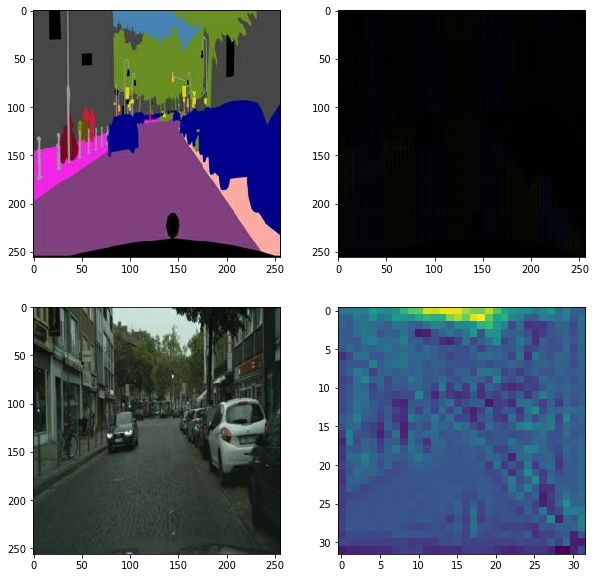

In [8]:
def generate_image(input_image, output_image):
    g_output = G(input_image, training=False)
    d_mask = D([input_image, output_image], training=False)
    
    plt.subplot(2, 2, 1)
    plt.imshow(input_image[0])
    
    plt.subplot(2, 2, 2)
    plt.imshow(g_output[0])
    
    plt.subplot(2, 2, 3)
    plt.imshow(output_image[0])

    plt.subplot(2, 2, 4)
    plt.imshow(d_mask[0, :, :, 0])


plt.figure(figsize=(10, 10))
generate_image(test_input_image[tf.newaxis, ...] / 255.0, test_output_image[tf.newaxis, ...] / 255.0)
plt.show()

In [9]:
@tf.function
def train_step(input_images, output_images):
    with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
        y_hat = G(input_images)
        true = D([input_images, output_images])
        false = D([input_images, y_hat])
        
        l1_loss = 100.0 * tf.reduce_mean(tf.abs(y_hat - output_images))
        fake_loss = keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(false), false)
        total_loss_g = l1_loss + fake_loss
        
        true_loss = keras.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(false), false)
        false_loss = keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(true), true)
        total_loss_d = (tf.reduce_mean(true_loss) + tf.reduce_mean(false_loss)) / 2.0
        
    g_grad = g_tape.gradient(total_loss_g, G.trainable_variables)
    d_grad = d_tape.gradient(total_loss_d, D.trainable_variables)
    
    g_opt.apply_gradients(zip(g_grad, G.trainable_variables))
    d_opt.apply_gradients(zip(d_grad, D.trainable_variables))
    
    return l1_loss, fake_loss, total_loss_g, true_loss, false_loss, total_loss_d


batch_input_images, batch_output_images = next(iter(train_dataset))
losses = train_step(batch_input_images, batch_output_images)
print(losses)

(<tf.Tensor: id=9078, shape=(), dtype=float32, numpy=32.626007>, <tf.Tensor: id=9079, shape=(), dtype=float32, numpy=0.69214535>, <tf.Tensor: id=9080, shape=(), dtype=float32, numpy=33.318153>, <tf.Tensor: id=9081, shape=(), dtype=float32, numpy=0.69418937>, <tf.Tensor: id=9082, shape=(), dtype=float32, numpy=0.68553543>, <tf.Tensor: id=9083, shape=(), dtype=float32, numpy=0.6898624>)


# Training

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


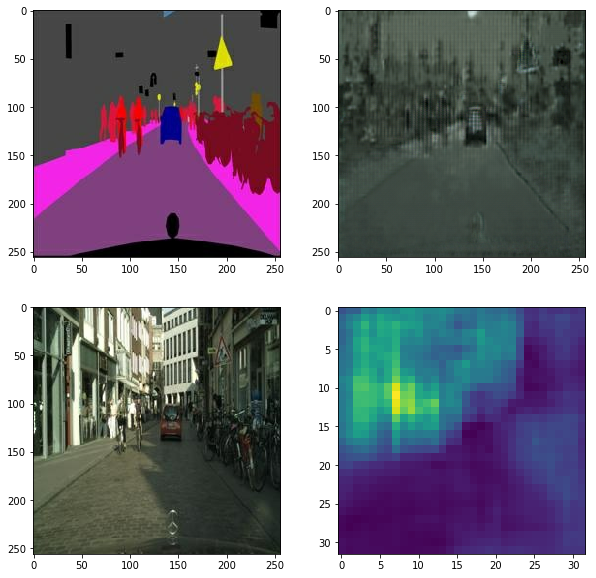

10 .
2974, l1: 10.893513, fake: 1.225360, g: 12.118874, d: 0.503940

In [10]:
def fit(train_ds, epochs, test_ds):
    for epoch in range(epochs):
        display.clear_output(wait=True)
        
        plt.figure(figsize=(10, 10))
        for test_input, test_output in test_ds.take(1):
            generate_image(test_input, test_output)
        plt.show()
        
        print(epoch+1, '.')
        losses = [[] for _ in range(6)]
        for n, (input_image, target) in train_ds.enumerate():
            l = train_step(input_image, target)
            for j in range(6):
                losses[j].append(l[j].numpy())
            print('\r%d, l1: %f, fake: %f, g: %f, d: %f' %
                  (n, np.mean(losses[0]), np.mean(losses[1]), np.mean(losses[2]), np.mean(losses[5])), end='')


fit(train_dataset, 10, test_dataset)

In [11]:
checkpoint = tf.train.Checkpoint()
checkpoint.save('../checkpoint/pix2pix/cityscapes.checkpoint')

'../checkpoint/pix2pix/cityscapes.checkpoint-1'

# Display Result

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


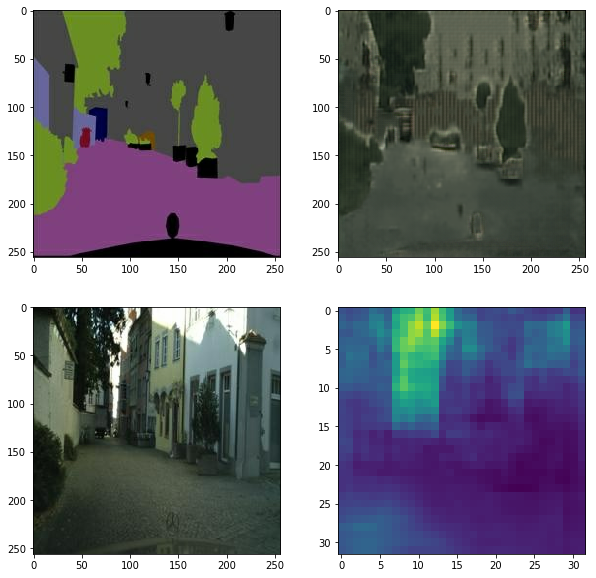

In [15]:
test_input_images, test_output_images = next(iter(test_dataset.take(1)))
plt.figure(figsize=(10, 10))
generate_image(test_input_images, test_output_images)
plt.show()

# Save Generator Model

In [17]:
tf.saved_model.save(G, '../models/pix2pix/cityscapes')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ../models/pix2pix/cityscapes/assets
